# Previsão de faturamento - Modelo autorregressivo ajustado ao produto `alimenticio`

<sub>Projeto para a disciplina de **Estatística** (Módulo 4) do Data Science Degree (turma de julho de 2020)</sub>

## Equipe

* Felipe Lima de Oliveira
* Mário Henrique Romagna Cesa
* Tsuyioshi Valentim Fukuda
* Fernando Raineri Monari

Link para [projeto no Github](https://github.com/flimao/case-previsao-faturamento)

## Introdução

Este notebook contém o modelo ajustado para o faturamento do produto `alimenticio` mês a mês.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# modelos
from pmdarima.arima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# metricas 
from sklearn.metrics import mean_absolute_percentage_error as smape, mean_squared_error as smse, mean_absolute_error as smae 

# importar scripts
cwd = os.getcwd()
os.chdir("../")
import py_scripts.plots, py_scripts.transform

os.chdir(cwd)

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120
mpl.rcParams['figure.figsize'] = (10, 4)

## Importação dos dados

In [2]:
ts_raw = pd.read_csv(r'../data/sim_ts_limpo.csv')
tsd, tswide = py_scripts.transform.pipeline(ts_raw)

produtos = tswide.columns
n_produtos = produtos.shape[0]

## Modelo autorregressivo - Faturamento do produto `alimenticio`

In [3]:
analise_produto = 'alimenticio'
fat = tswide['alimenticio'].dropna()

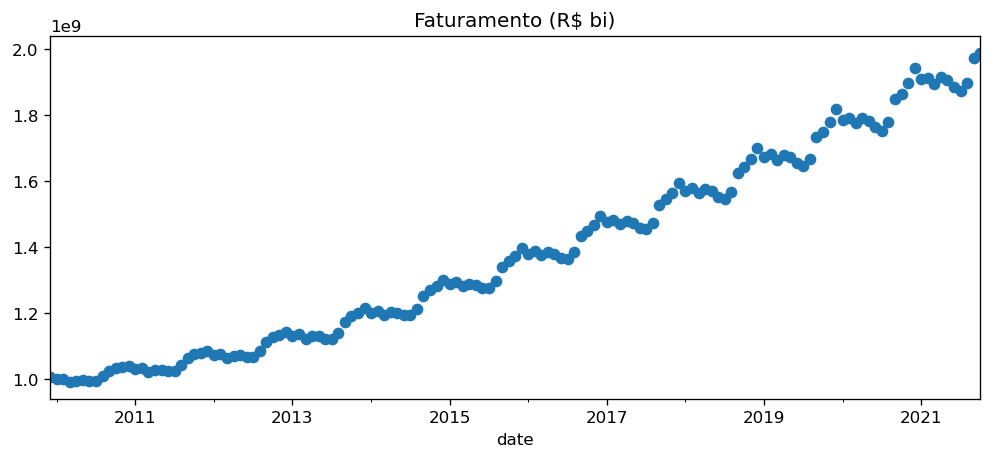

In [4]:
fat.plot(linestyle = '', marker = 'o')
plt.title('Faturamento (R$ bi)')
plt.show()

Para analisar e prever essa série temporal, é necessário um modelo mais completo. Utilizaremos aqui um modelo autorregressivo integrado de média móvel com sazonalidade - **SARIMA**.

OBS.: o modelo completo chama-se SARIMAX; o `X` adicional permite a modelagem de variáveis exógenas. No entanto, não utilizaremos variáveis exógenas neste caso.

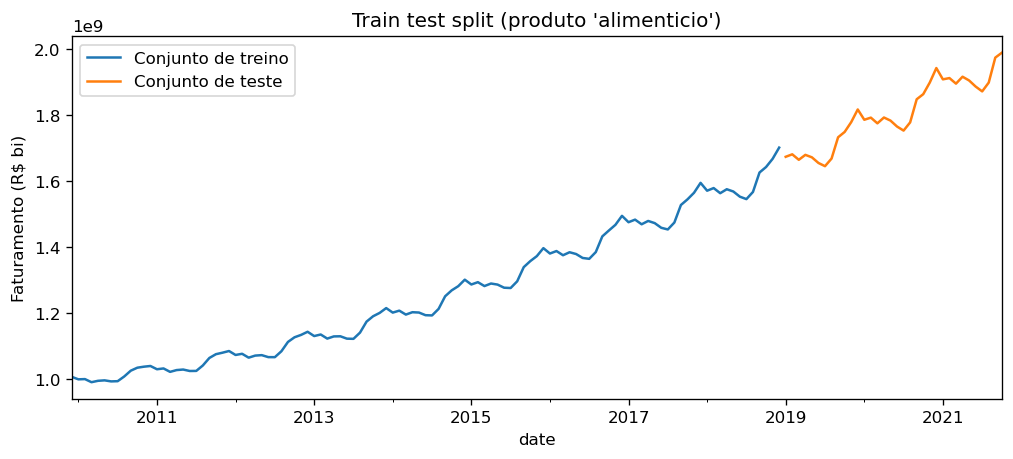

In [5]:
test_begin = '2019-01-01'
fat_train = fat[:test_begin].iloc[:-1]
fat_test = fat[test_begin:]

fat_train.plot(label = 'Conjunto de treino')
fat_test.plot(label = 'Conjunto de teste')
plt.title(f"Train test split (produto '{analise_produto}')")
plt.ylabel('Faturamento (R$ bi)')
plt.legend()
plt.show()

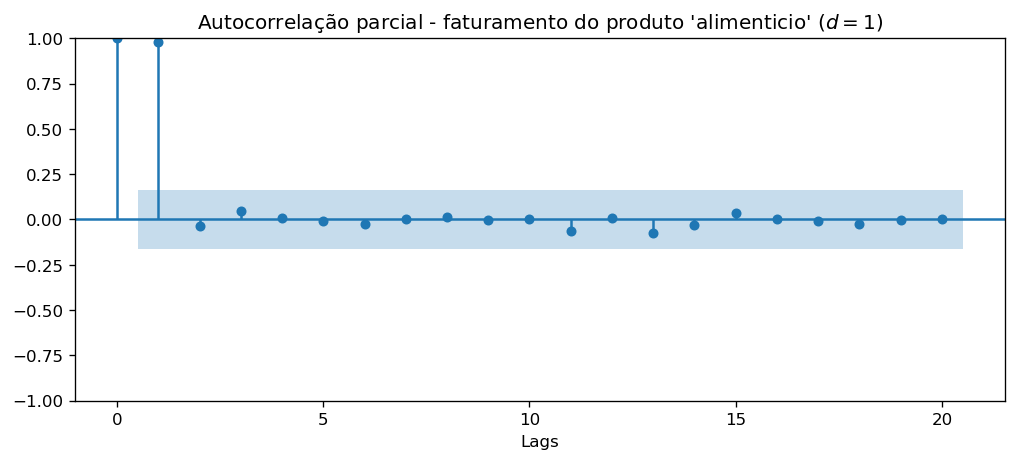

In [6]:
fig = plt.figure()
ax = fig.gca()
plot_pacf(fat, lags = 20, method = 'ywm', ax = ax)
ax.set_xlabel('Lags')
ax.set_title(f"Autocorrelação parcial - faturamento do produto '{analise_produto}' ($d = 1$)")
plt.show()

In [7]:
modelo = auto_arima(
    y = fat_train,
    start_p = 1, max_p = 3,
    d = None, max_d = 4,
    start_q = 1, max_q = 3,
    start_P = 1, max_P = 3,
    D = None, max_D = 4,
    start_Q = 1, max_Q = 3,
    #max_order = 6,
    m = 12,
    seasonal = True
    #alpha = 0.05
)

In [8]:
modelo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  109
Model:             SARIMAX(0, 1, 0)x(1, 2, 0, 12)   Log Likelihood               -1244.831
Date:                            Tue, 16 Nov 2021   AIC                           2495.663
Time:                                    20:21:04   BIC                           2502.955
Sample:                                         0   HQIC                          2498.594
                                            - 109                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -6.597e+04   7.66e+04     -0.861      0.389   -2.16e+05    8.42e+04
ar.S.L12       0.0015      0.024      0.061      0.951      -0.046       0.049
sigma2      4.615e+11      0.018   2.53e+13      0.000    4.62e+11    4.62e+11
===================================================================================
Ljung-Box (L1) (Q):                   9.86   Jarque-Bera (JB):                 2.15
Prob(Q):                              0.00   Prob(JB):                         0.34
Heteroskedasticity (H):               2.06   Skew:                             0.36
Prob(H) (two-sided):                  0.06   Kurtosis:                         3.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.63e+29. Standard errors may be unstable.
"""

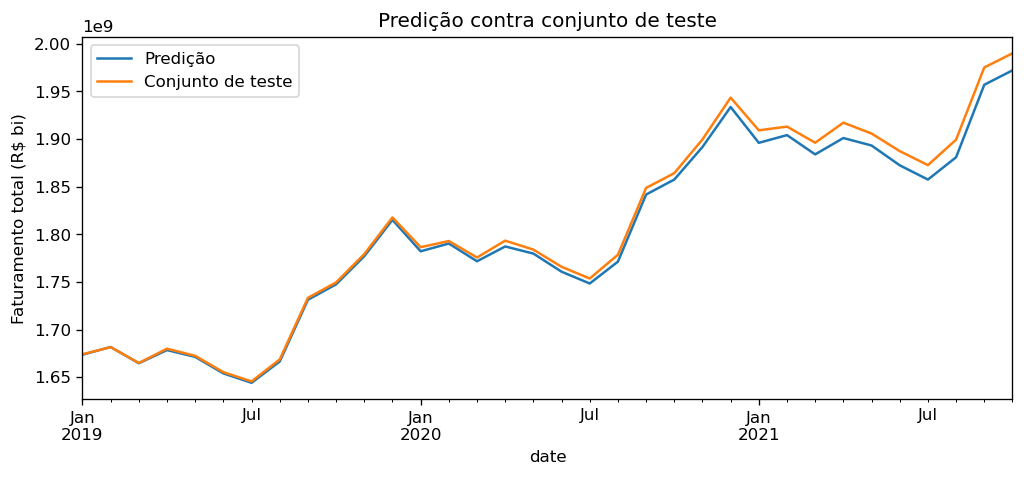

In [9]:
n_test_periods = fat_test.shape[0]
arr_preds = modelo.predict(n_test_periods)

idx = pd.date_range(freq = 'MS', start = test_begin, periods = n_test_periods)
preds = pd.Series(arr_preds, index = idx)
preds.name = 'yearly_preds'

preds.plot(label = 'Predição')
fat_test.plot(label = 'Conjunto de teste')

plt.legend()
plt.ylabel('Faturamento total (R$ bi)')
plt.title('Predição contra conjunto de teste')
plt.show()

Vamos aplicar algumas métricas ao modelo:

In [10]:
kwargs_ajuste = dict(
    y_true = fat_test,
    y_pred = preds
)

mape = smape(**kwargs_ajuste)
rmse = np.sqrt(smse(**kwargs_ajuste))
mae = smae(**kwargs_ajuste)

print(f'MAPE: {mape:.3%}')
print(f'RMSE: {rmse:.3e}')
print(f' MAE: {mae:.3e}')

MAPE: 0.368%
RMSE: 8.988e+06
 MAE: 6.905e+06
